# Implementation of DFS, BFS, Dijkstra algorythm
## By Igor Markevych

In [1]:
library(igraph)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



_create matrix_

In [2]:
n <- 20
mat <- matrix(replicate(n*n, round(abs(rnorm(1)) * (rnorm(1) > 1), 3)), nrow=n)

_create graph from matrix and plot it_

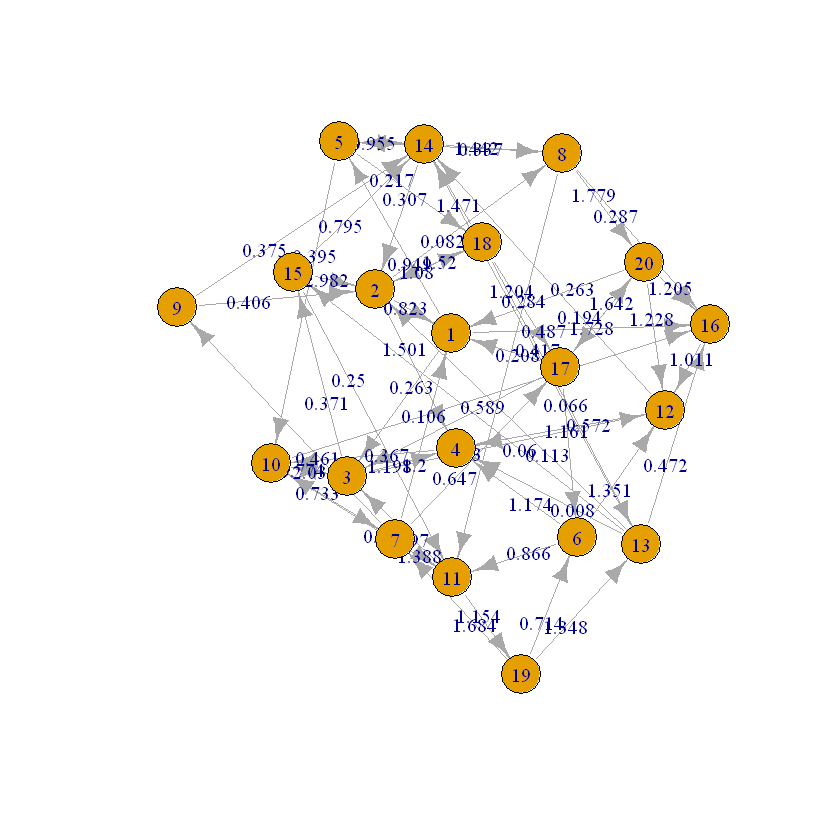

In [3]:
g <- graph_from_adjacency_matrix(mat, weighted=T, mode='directed', diag=F)
vertex_attr(g, 'label') <- 1:n
plot(g, edge.label=E(g)$weight)

_plot graph with green start, blue goal and red other path_  
_specify `plotWeights` as `T` to get weights of edges of path also plotted_

In [4]:
plotPath <- function(g, path, plotWeights=F){
    if(typeof(path) == 'logical'){
        return(FALSE)
    }
    edge_attr(g, "color") = "grey"
    for(i in 2:length(path)){
       edge_attr(g, "color", index = E(g)[path[i-1] %->% path[i]]) <-  "red" 
    }
    V(g)$color <- ifelse(V(g) %in% path, 'red', 'grey')
    V(g)[V(g)$label == path[1]]$color  <- 'green'
    V(g)[V(g)$label == path[length(path)]]$color  <- 'blue'
    if(plotWeights){
        for(i in 2:length(path)){
            edge_attr(g, "label", index = E(g)[path[i-1] %->% path[i]])  <- 
                edge_attr(g, "weight", index = E(g)[path[i-1] %->% path[i]])
        }
    }
    plot(g)
}

# Depth-First Search

Cycle:  
  
1. Add current node (`prevNode`) to the `path`.
1. Take first from current node neighbors.
    1. Check if we have already visited this neighbor.
        1. If yes, select next neighbor. 
        1. Repeat until we'll get an unvisited node.
    1. If we have visited all of neighbors:
        1. Delete this node. Go to previous one.
    1. Repeat again, if needed, go to another previous node.
1. Check whether current node is `goal` node.
1. Check if current node has any neighbors. 
    1. If no, delete it from frontier.


In [5]:
DFS <- function(g, start, goal){
    if(length(neighbors(g, start)) == 0 | length(neighbors(g, goal, mode='in')) == 0){
        return(F)
    }
    if(start == goal){
        return(start)
    }
    prevNode <- V(g)[V(g)$label == start] 
    frontier <- g
    path <- c()
    k <- 1
    while(length(frontier) > 0) {
        k <- k + 1
        path <- c(path, prevNode$label) 
        
        if(path[length(path)] == goal){
            return(path)
        }
        
        nextNode <- neighbors(frontier, V(frontier)[V(frontier)$label == prevNode$label])[1]
        i <- 1
        while(nextNode$label %in% path){
            i <- i + 1
            while(i > length(neighbors(frontier, V(frontier)[V(frontier)$label == prevNode$label]))){
                frontier <- delete_vertices(frontier, V(frontier)[V(frontier)$label == prevNode$label])
                prevNode <- V(frontier)[V(frontier)$label == path[length(path)]]
                path <- path[-length(path)]
                i <- 2
            }
            nextNode <- neighbors(frontier, V(frontier)[V(frontier)$label == prevNode$label])[i]
        }
        prevNode <- nextNode

        while(length(neighbors(frontier, V(frontier)[V(frontier)$label == prevNode$label])) == 0){   
            frontier <- delete_vertices(frontier, V(frontier)[V(frontier)$label == prevNode$label])
            prevNode <- V(frontier)[V(frontier)$label == path[length(path)]]
            path <- path[-length(path)]
        }
    }
    return(F)
}

In [6]:
dfs.res <- DFS(g, '1', '7')
dfs.res

[1]  1  3  4 10  7

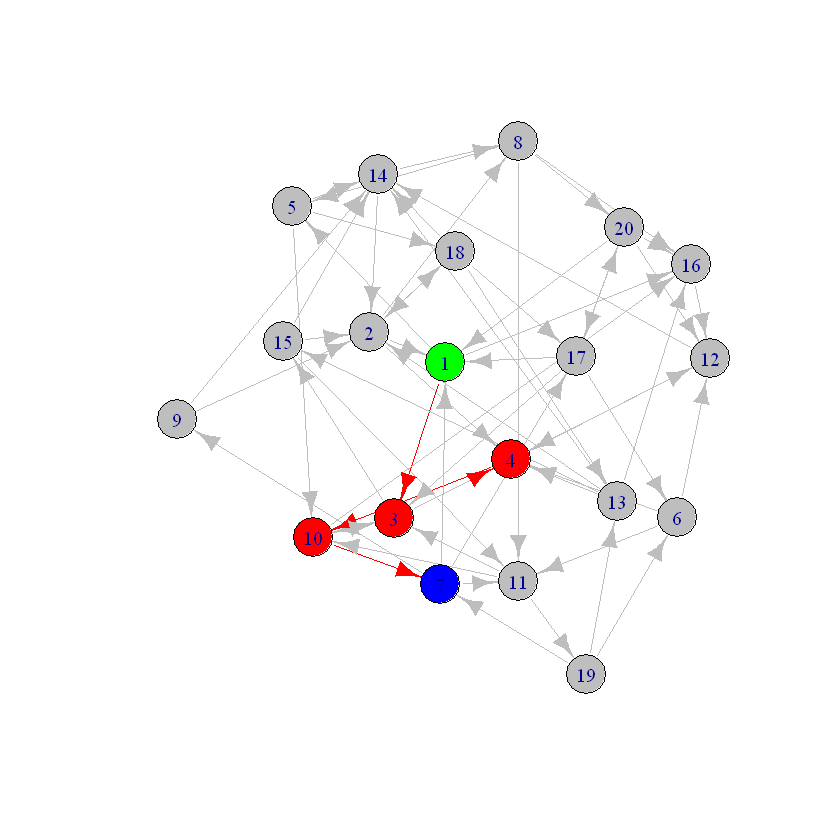

In [7]:
plotPath(g, dfs.res)

# Breadth-First Search

Cycle:

1. Create a level from neighbors of previous level
1. Check whether we have goal inside this level.

For finding path:

1. Take levels from BFS.
1. Put goal variable into path.
1. Cycle:
    1. Take last element of path.
    1. Find node from last level that is linked with last element of path.
    1. Append label of this node to path.
    1. Delete last level.
1. Return reversed path.    

In [8]:
BFS <- function(g, start, goal){
    
    start <- V(g)[V(g)$label == start]  
    goal <- V(g)[V(g)$label == goal]
    
    findPath <- function(levels, start, goal){
        path <- goal$label
        prevNode <- goal
        while(length(levels) > 0){
            prevLevel <- levels[[length(levels)]]
            levels <- levels[-length(levels)]
            prevNode <- prevLevel[unlist(lapply(prevLevel, are.connected, graph=g, v2=prevNode))][1]
            path <- c(path, prevNode)
        }
        return(rev(path))
    }
    
    
    if(length(neighbors(g, start)) == 0 | length(neighbors(g, goal, mode='in')) == 0){
        return(F)
    }
    if(start == goal){
        return(start)
    }
    levels <- list()
    prevLevel <- start 
    while(length(prevLevel) > 0) {
        curLevel <- c()
        for(curNode in prevLevel){
            if(curNode == goal){
                return(findPath(levels, start, goal))  
            }
            curLevel <- c(curLevel, neighbors(g, curNode))
        }
        levels <- append(levels, list(prevLevel))
        prevLevel <- curLevel
    }
    return(F)
}

In [9]:
bfs.res <- BFS(g, '1', '7')
bfs.res

[1]  1  3 10  7

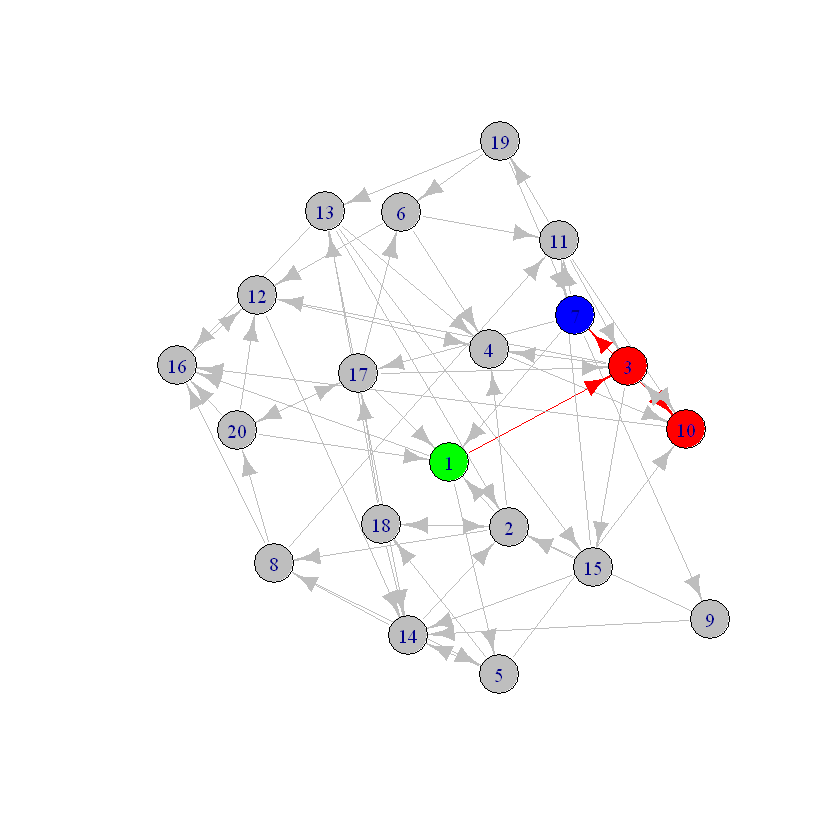

In [10]:
plotPath(g, bfs.res)

# Uniform-Cost Search
## (Dijkstra’s algorithm)

In [11]:
getCost <- function(path){
    sum <- 0
    for(i in 2:length(path)){
        sum <- sum + edge_attr(g, "weight", index = E(g)[path[i-1] %->% path[i]])
    }
    return(sum)
}

findSmallestCostVertex <- function(g){
    V(g)[which.min(vertex_attr(g, 'cost'))]
}

[Algorythm](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%94%D0%B5%D0%B9%D0%BA%D1%81%D1%82%D1%80%D1%8B)  
$Cost\_neigh = cost\_curNode + edge\_weight$  
After we have checked all neightbors of current node we delete it from frontier.  
We set `prevNode` attribute for returning path.

In [12]:
UCS <- function(g, start){
    
    start <- V(g)[V(g)$label == start]  
    
    vertex_attr(g, 'cost') <- Inf
    vertex_attr(g, 'cost', index = V(g)[V(g)$label == start]) <- 0
    
    frontier <- g
    
    while(length(V(frontier)) > 0){
        
        if(all(!is.finite(vertex_attr(g, 'cost')))){
            return(F)
        }
        
        curNode <- findSmallestCostVertex(frontier)$label
        
        for(nextNode in neighbors(frontier, V(frontier)$label == curNode)$label){
            tempCost <- vertex_attr(g, 'cost', index = V(g)[V(g)$label == curNode]) +
                        edge_attr(g, "weight", index = 
                                    E(g)[V(g)[V(g)$label == curNode] %->% V(g)[V(g)$label == nextNode]])

            if(tempCost < vertex_attr(g, 'cost', index = V(g)[V(g)$label == nextNode])){
                vertex_attr(g, 'cost', index = V(g)[V(g)$label == nextNode]) <- tempCost
                vertex_attr(g, 'prevNode', index = V(g)[V(g)$label == nextNode]) <- curNode
                
                vertex_attr(frontier, 'cost', index = V(frontier)[V(frontier)$label == nextNode]) <- tempCost
            }
        }
        frontier <- delete_vertices(frontier, V(frontier)[V(frontier)$label == curNode])
    }
    
    return(g)
}

In [13]:
findPathForUCS <- function(g, start, goal){
    ucs <- UCS(g, start)
    path <- goal
    while(path[length(path)] != start){
        path <- c(path, vertex_attr(ucs, 'prevNode', index = V(g)[V(g)$label == path[length(path)]]))
    }
    return(rev(path))
}

_**NOTE**: UCS returns graph with `cost` attribute of each vertex. This attribute is cost of going from _

In [14]:
ucs.res <- findPathForUCS(g, '1', '7')
ucs.res
cat('Optimal cost is:\n')
vertex_attr(UCS(g,'1'), 'cost', index = V(g)[V(g)$label == '7'])

[1] "1"  "3"  "15" "11" "10" "7"

Optimal cost is:


[1] 1.686

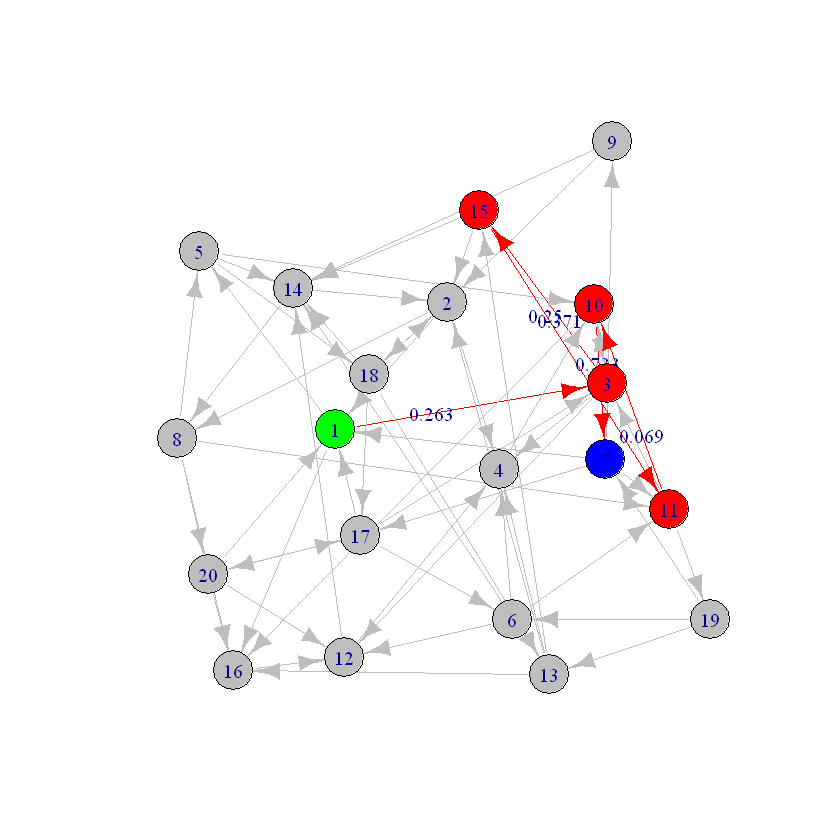

In [15]:
plotPath(g, ucs.res, plotWeights = T)